<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Inverse Problems</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Probabilistic estimation of hypocenter</div>
        </div>
    </div>
</div>

##### Authors:
* Kilian Geßele ([@KGessele](https://github.com/KGessele))

## Basic Equations

a programme to use probabilistic inverse theory 
to determine hypocenter locations (highly simplified)
here simplified to a 2D problem, but extendable to 3D

$$
\rho (\mathbf{d},\mathbf{m}) = \rho_D (\mathbf{d}) \; \rho_M (\mathbf{m})
$$

$$
\sigma (\mathbf{d},\mathbf{m}) = k \; \frac{\rho (\mathbf{d},\mathbf{m}) \; \Theta(\mathbf{d},\mathbf{m})}{\mu(\mathbf{d},\mathbf{m})}
$$

$$
\sigma_M(\mathbf{m}) = k \; \rho_M (\mathbf{m}) \; \int_\mathcal{D} d\mathbf{d} \;
\frac{\rho_D (\mathbf{d}) \; \theta(\mathbf{d} \ | \ \mathbf{m})}{\mu_D(\mathbf{d})}
$$

In [1]:
# This is a configuration step for the exercise
# ---------------------------------------------

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15,6
plt.rcParams['axes.titlepad'] = 10

In [6]:
# Setup for data and model
#------------------------

# Define station coordinates    # (original values)
xstation = np.array([ 5,10,15,25])    # x(km) = [ 5,10,15,25]
zstation = np.array([ 0, 0, 0, 0])    # z(km) = [ 0, 0, 0, 0]

# Define uncertainties of the oberservations for each station
sobs = np.array([.5, .2, .3, .2])  # [.5,.2,.3,.2]

# Define source properties
xsource = 30                         # source location x = 30
zsource = 15                         # source location z = 15
t0 = 17                         # origin time = 17
v  =  5                         # homogeneous velocity (km/s) = 5

# For model exploration: upper bound | lower bound | increments
xl =  0;  xu = 35;  xinc = .5   # for x: 0, 35, 0.5
zl =  0;  zu = 25;  zinc = .5   # for z: 0, 25, 0.5
Tl = 10;  Tu = 30;  Tinc = .25  # for time: 10, 30, 0.25

In [11]:
# Calculating exact data and sovling the inverse problem
#-------------------------------------------------------

#Warning, if data setup is wrong
if np.array([xstation, zstation, sobs]).size != xstation.size*3:
        print('ERROR: xstation, zstation and sobs should have same length')
        

# Calculate exact data
tobs = np.zeros(np.size(xstation))
for i in range(0,np.size(xstation)):  # Loop over number of stations
    tobs[i] = t0 + 1/v * np.sqrt((xstation[i]-xsource)**2 + (zstation[i]-zsource)**2)

    
# Setup for model space exploration and a posteriori pdf
xspace = np.arange(xl, xu + xinc, xinc)         # Array of x elements
zspace = np.arange(zl, zu + zinc, zinc)         # Array of z elements
Tspace = np.arange(Tl, Tu + Tinc, Tinc)         # Array of T elements
sigM = np.ones([xspace.size, zspace.size, Tspace.size]) # Initilization of pdf
print('Calculation of a posteriori pdf for %i samples '%(xspace.size*zspace.size*Tspace.size))
input('Press ENTER to continue')


# Solution of the inverse problem
# Loop through model space
for i,x in enumerate(xspace):
    for j,z in enumerate(zspace):
        for k,T in enumerate(Tspace):
            for n in range(0,np.size(xstation)):   # Loop over number of stations
                    
                # Calculate forward problem
                t = T + 1/v * np.sqrt((x-xstation[n])**2 + (z-zstation[n])**2)
                    
                # Calculate the associated probability
                sigM[i,j,k] *= np.exp(-(t-tobs[n])**2 / (2*sobs[n]**2))            
    
           
# Calculate the marginal a posteriori probability for the x-z-plane
sigMxz = np.zeros([xspace.size, zspace.size])
for i in range(0,xspace.size):
    for j in range(0,zspace.size):
        sigMxz[i,j] = np.sum(sigM[i, j, :])
sigMxz /= np.max(sigMxz)     # Normalization for plotting


# Calculate the marginal a posteriori for T
sigMT = np.zeros(Tspace.size)
for i in range(0,Tspace.size):
    sigMT[i] = np.sum(sigM[:, :, i])
sigMT /= np.max(sigMT)        # Normalization for plotting

Calculation of a posteriori pdf for 293301 samples 
Press ENTER to continue


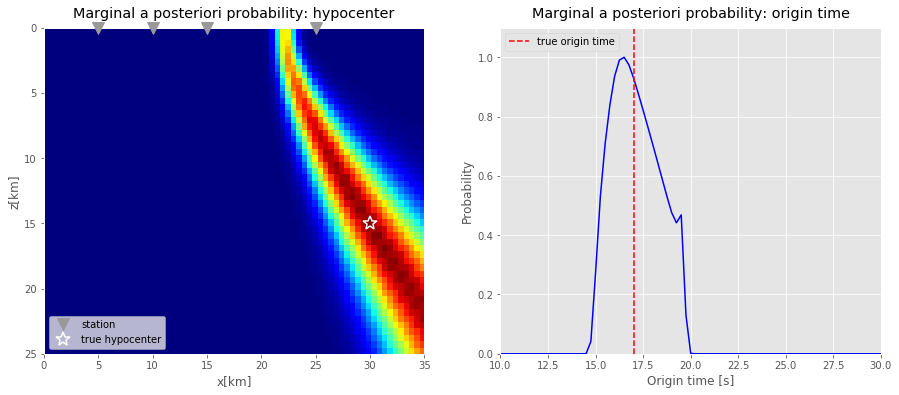

In [12]:
# Plotting solution for the inverse problem
#----------------

#Plot a 2D marginal posteriori pdf for x-z-plane
plt.subplot(1,2,1)
plt.plot(xstation,zstation, 'v', color='0.60', markersize=12, clip_on=False,zorder=10, label='station')
plt.plot(xsource,zsource,'w*', markersize=15,markerfacecolor='None',markeredgewidth=1.5,label='true hypocenter')
plt.imshow(sigMxz.transpose(), aspect='auto', extent= [xl, xu, zu, zl],cmap=plt.cm.jet)
plt.xlabel('x[km]')
plt.ylabel('z[km]')
plt.title('Marginal a posteriori probability: hypocenter')
plt.legend(loc='lower left')
plt.grid()

#Plot a marginal posteriori pdf for origin time
plt.subplot(1,2,2)
plt.plot(np.arange(Tl, Tu+Tinc, Tinc), sigMT, 'b-')
plt.plot([t0,t0],[0,sigMT.max()*1.1],'r--',label='true origin time')
plt.xlabel('Origin time [s]')
plt.ylabel('Probability')
plt.title('Marginal a posteriori probability: origin time')
plt.xlim(Tl,T)
plt.ylim(0,sigMT.max()*1.1)
plt.legend(loc='upper left')
plt.show()